In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## 1. Description

### About
Twitter has become a crucial communication channel in emergencies. The ubiquity of smartphones enables people to announce emergencies they're observing in real-time. Consequently, more agencies are interested in programmatically monitoring Twitter (e.g., disaster relief organizations and news agencies). However, it's not always clear whether a person's words are actually announcing a disaster.
### Objective
The goal is to distinguish fake news from real news by training a model that can make this distinction. I'll start with a short section on text mining and then contrast different concepts from N-grams to embeddings to transformers.

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

# Display first few rows of the dataset
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print(f"The size of train data: {train_data.shape[0]}")
print(f"The size of test data: {test_data.shape[0]}")
print(f"Target counts:\n{train_data['target'].value_counts()}")

The size of train data: 7613
The size of test data: 3263
Target counts:
target
0    4342
1    3271
Name: count, dtype: int64


## 2. EDA

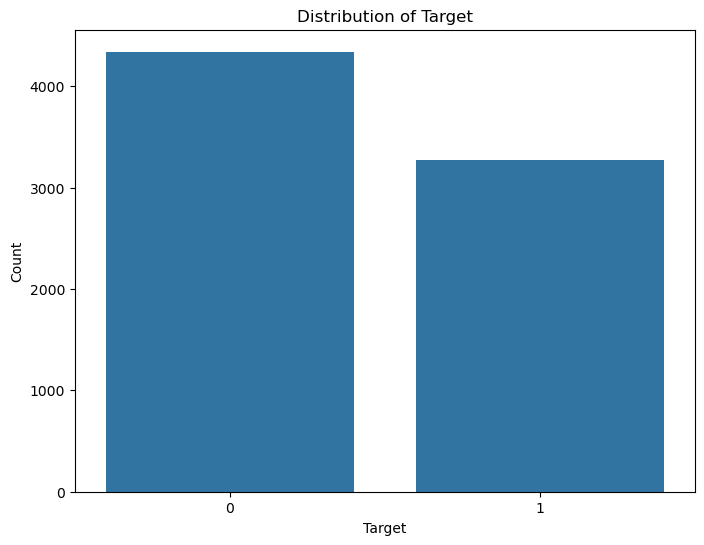

In [10]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_9239/3920671198.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_locations.index, x=top_locations.values, palette='viridis')


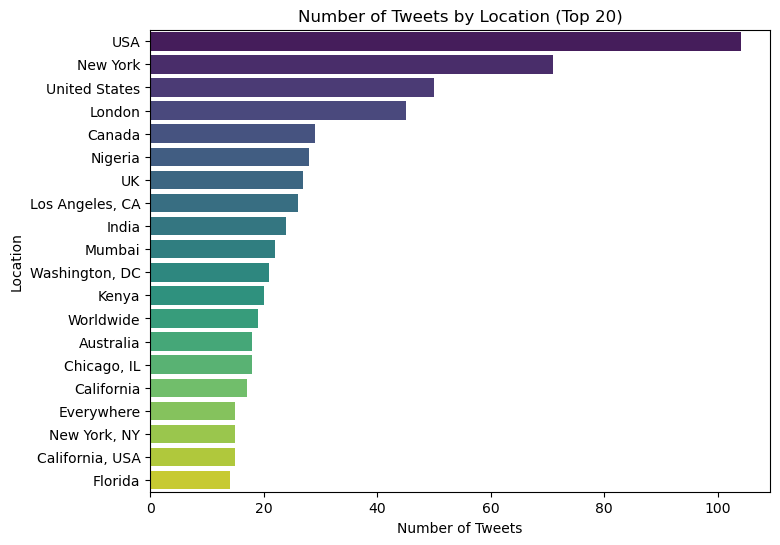

In [5]:
# Visualizing number of tweets by location
plt.figure(figsize=(8, 6))
top_locations = train_data['location'].value_counts().head(20)
sns.barplot(y=top_locations.index, x=top_locations.values, palette='viridis')
plt.title('Number of Tweets by Location (Top 20)')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.show()


/var/folders/tt/bg81xkx10n788vrk6hd47xs80000gn/T/ipykernel_9239/2838904496.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_keywords.index, x=top_keywords.values, palette='viridis')


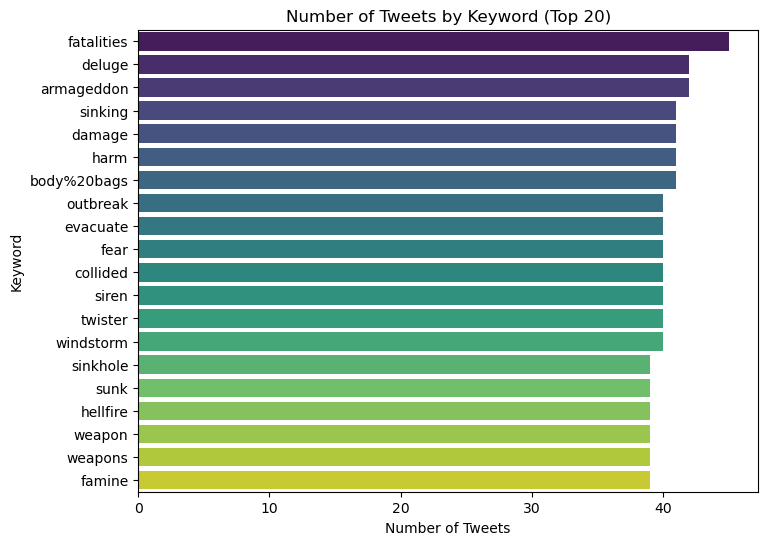

In [6]:
# Visualizing number of tweets by keyword
plt.figure(figsize=(8, 6))
top_keywords = train_data['keyword'].value_counts().head(20)
sns.barplot(y=top_keywords.index, x=top_keywords.values, palette='viridis')
plt.title('Number of Tweets by Keyword (Top 20)')
plt.xlabel('Number of Tweets')
plt.ylabel('Keyword')
plt.show()


Compare the distributions of text lengths between the train and test datasets.

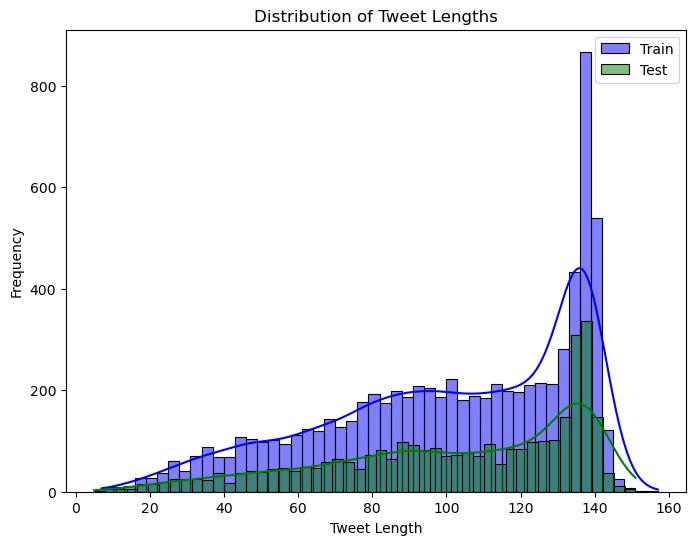

In [11]:
# Plot the distribution of tweet lengths
plt.figure(figsize=(8, 6))
sns.histplot(train_data['text'].apply(len), bins=50, kde=True, color='blue', label='Train')
sns.histplot(test_data['text'].apply(len), bins=50, kde=True, color='green', label='Test')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Missing

The location variable have significant missing values.

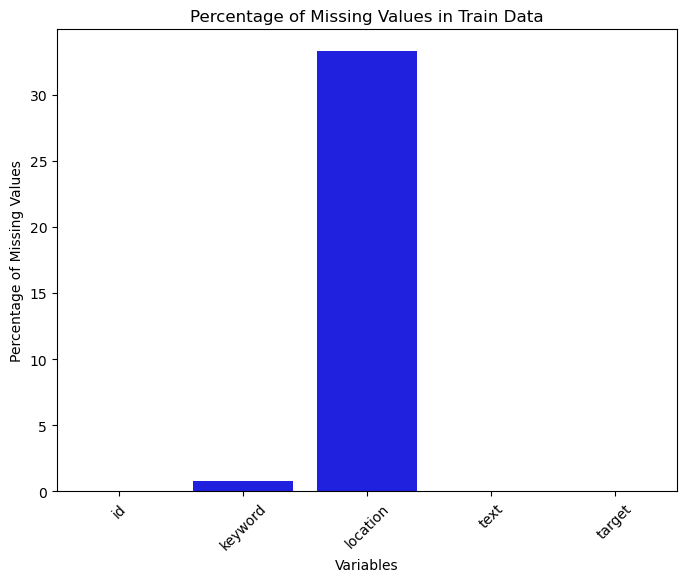

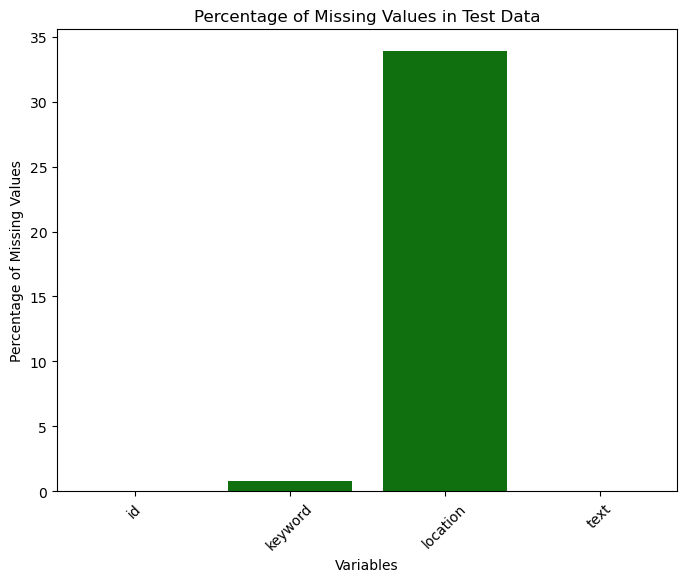

In [7]:
# Calculate the percentage of missing values for each column in train and test datasets
missing_train = (train_data.isnull().sum() / train_data.shape[0]) * 100
missing_test = (test_data.isnull().sum() / test_data.shape[0]) * 100

# Filter out columns with no missing values
missing_train = missing_train
missing_test = missing_test

# Plot the missing values for the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(x=missing_train.index, y=missing_train.values, color='blue')
plt.title('Percentage of Missing Values in Train Data')
plt.xlabel('Variables')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45)
plt.show()

# Plot the missing values for the test dataset
plt.figure(figsize=(8, 6))
sns.barplot(x=missing_test.index, y=missing_test.values, color='green')
plt.title('Percentage of Missing Values in Test Data')
plt.xlabel('Variables')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45)
plt.show()


In [8]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

train_data.head()


,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...
